# Gaussian Processes

This notebooks aims to demonstrate what a Gaussian Process (GP) is and how Gaussian Process Regression (GPR) works.  The methods used in the notebook **should not** be used in production, they do not scale well to larger problems and can be numerically unstable.

## Definition

> A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution
>
> https://en.wikipedia.org/wiki/Gaussian_process

Let's break down what this means.  In our case the stochastic process is a function presented as an N-element vector (N is the number of points the functions is evaluated at).  Each of these N values are drawn from an N-D gaussian distribution with a **fixed** mean $\mu$ and covariance $\Sigma$.  Every draw from this distribution creates a new function, this creates a infinite family of functions that belong to the same GP.

GPR asks a slightly different question:  Given a set of observed points, assume a GP gave rise to the data and find the set of functions belonging to the GP that **pass through** the observed data points.  I.e. condition the GPs distribution on the observed data.  Because of the nice mathematical properties of multi-normal distributions, this conditioning also produces a GP.  The mean $\mu^*$ and covariance $\Sigma^*$ of this conditioned GP act as the best fit and confidence region of the resulting regression problem.

## Visualizations

Now that we have an idea what a GP and GPR are, let's write some code to visualize these definitions.  Throughout this notebook we will be using numpy and scipy for the linear algebra and matplotlib for plotting.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import multivariate_normal, norm


### Making $\Sigma$

Before we can fit a GP to some data we need to pick a $\mu$ and $\Sigma$ for the fit.  For simplicity we will take $\mu$ to be 0, in practice $\mu$ would be the typical functional form you would want to fit to you data (e.g. a spectral line profile).  $\Sigma$ on the other hand models the covariance of the GP, this is the main quantity you have control over when doing GPR.  Ideally this should be physically motivated by the data you are trying to fit (e.g. there is a know corelation scale in the data).  If you don't have a strong motivation for a particular $\Sigma$ there are a set of standard functions that can be used as building blocks.  The simplest $\Sigma$ building block is the squared exponential kernel (in the GP literature the functional form of $\Sigma$ is called a kernel):

$$
K(x_1, x_2; h) = \exp\left({\frac{-(x_1 - x_2)^2}{2 h^2}}\right)
$$

The Squared exponential kernel is a function of the distance between its input points and a single length scale $h$.  From this functional form we can start to get an understanding about how functions drawn from this GP should act: point closer together will be more similar than points far apart.  We expect this will create smooth functions that "wiggle" on a length scale of $h$.

Now let's looks at some code that can draw some functions from this kernel.

In [2]:
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x2 - x1)**2 / h**2)

# number of evaluation points
N = 101
# the evaluations points
x_star = np.linspace(0, 5, N)

# set the length scale
h = 1

# Mean of zero
μ = np.zeros(N)
# Build a NxN covariance matrix
# use numpy's shape broadcasting between a row vector
# and column vector to create the NxN shape
Σ = squared_exponential(x_star[:, None], x_star, h)


Now we will draw six random functions from the GP.  Most of the code below is for the resulting plots, the actual draw happens in the first line.

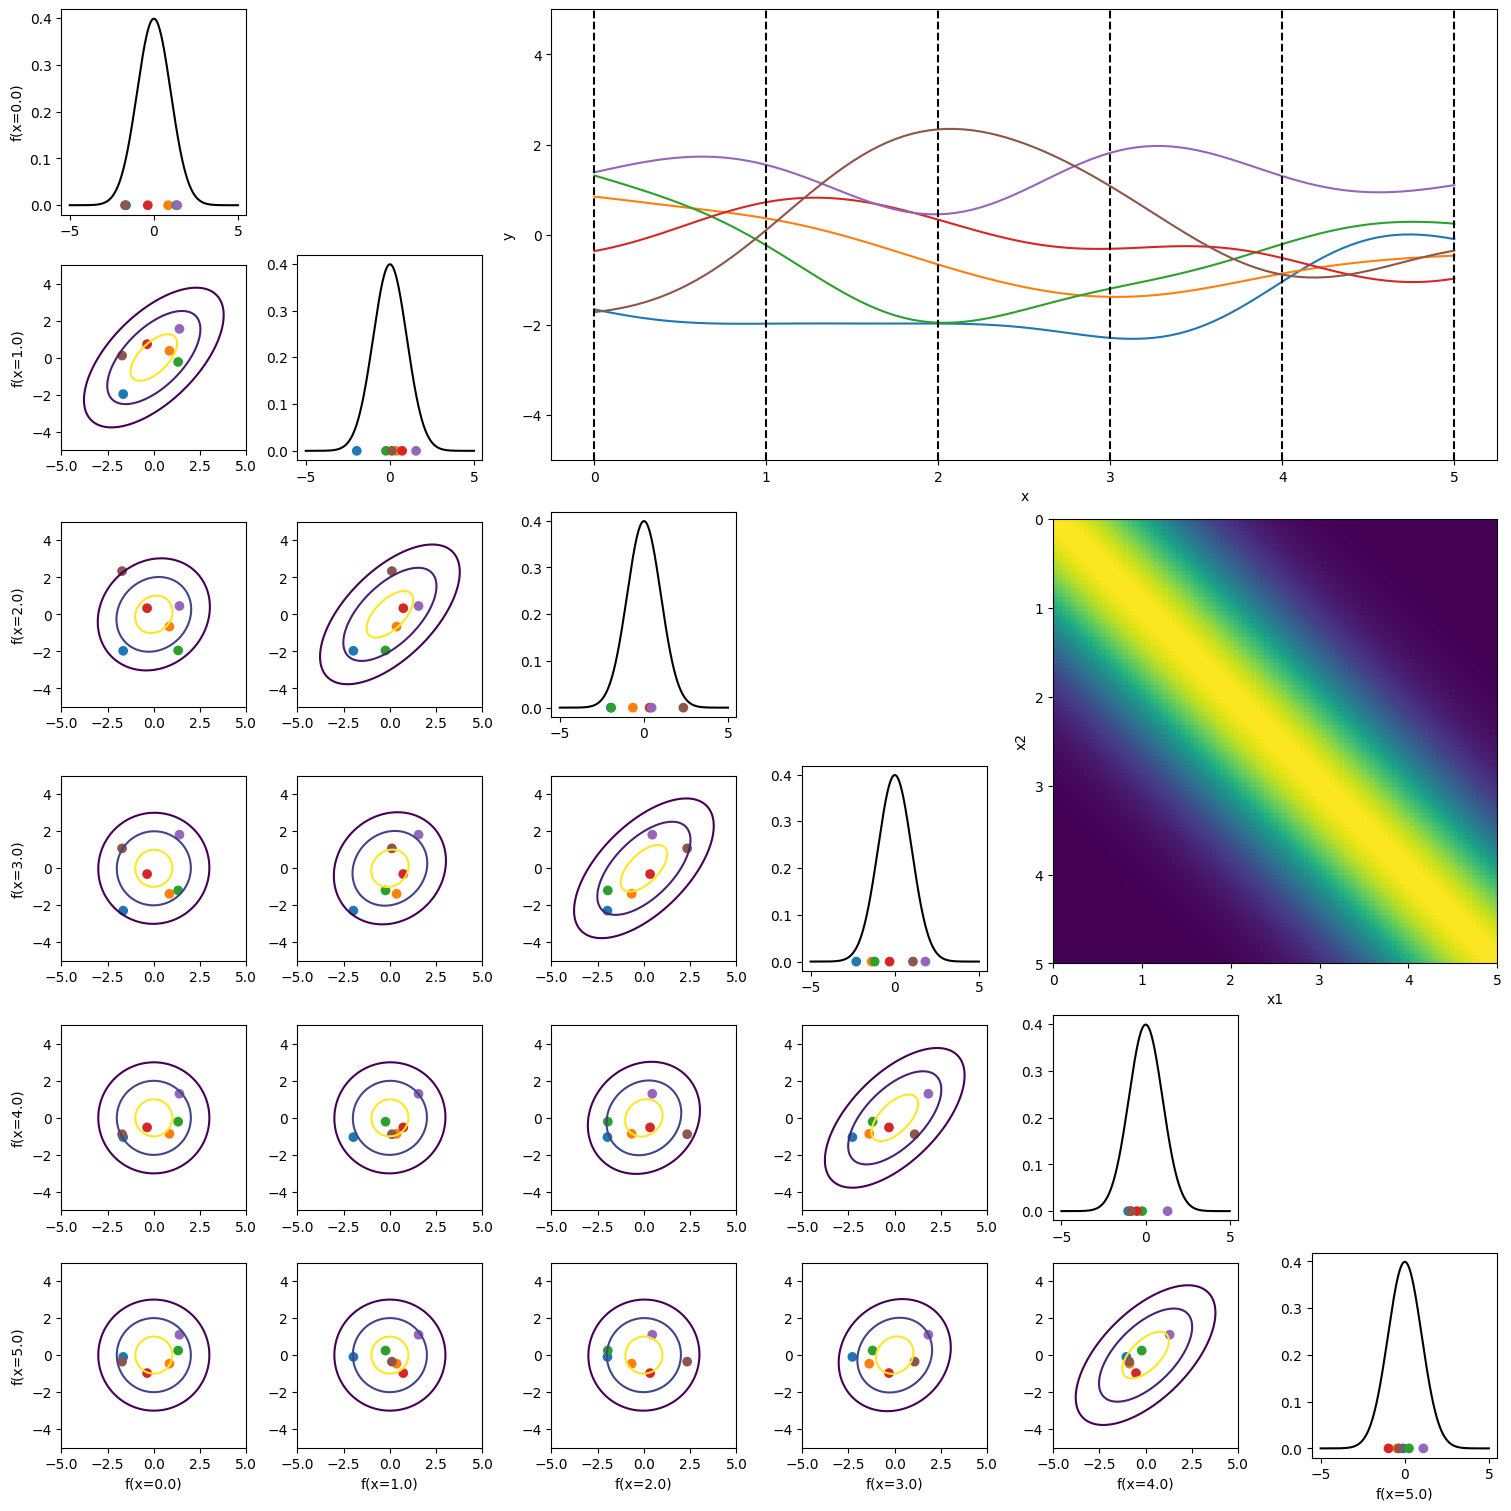

In [3]:
# draw from distribution
draws = np.random.multivariate_normal(μ, Σ, 6)

# number of columns to plot
N_cols = 6

# where to evaluate the 2D normal distribution slices
xvals, yvals = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((xvals, yvals))

# make a figure
fig1 = plt.figure(constrained_layout=True, figsize=(15, 15))
# define the subplots using gridspec
spec1 = gridspec.GridSpec(ncols=N_cols, nrows=N_cols, figure=fig1)

col_x = np.linspace(0, N - 1, N_cols, dtype=int)

# plot draws from the prior
ax = fig1.add_subplot(spec1[0:2, 2:])
ax.plot(x_star, draws.T)
# reference vertical lines
ax.vlines(x_star[col_x], -5, 5, linestyles='dashed', colors='k')
# plot formatting
ax.set_ylim(-5, 5)
ax.set_xlabel('x')
ax.set_ylabel('y')

# plot cov matrix
ax = fig1.add_subplot(spec1[2:4, 4:6])
ax.imshow(Σ, interpolation='none', origin='upper', extent=[0, 5, 5, 0])
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# corner plot
for ci, idx in enumerate(col_x):
    for cj, jdx in enumerate(col_x):
        if idx > jdx:
            ax = fig1.add_subplot(spec1[ci, cj])
            sub_μ = μ[[idx, jdx]]
            sub_Σ = Σ[[[idx], [jdx]], [idx, jdx]]
            rv = multivariate_normal(sub_μ, sub_Σ)

            rv_sigma=[
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 3 * sub_Σ[1, 1]**0.5))),  # 3-σ
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 2 * sub_Σ[1, 1]**0.5))),  # 2-σ
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 1 * sub_Σ[1, 1]**0.5)))   # 1-σ
            ]
            ax.contour(yvals, xvals, rv.pdf(pos), rv_sigma)
            xi = draws[:, col_x[ci]]
            xj = draws[:, col_x[cj]]
            plt.scatter(xj, xi, c=[f'C{i}' for i in range(6)])
            ax.set_aspect(1)
            ax.set_ylim(-5, 5)
            ax.set_xlim(-5, 5)
            if jdx == 0:
                ax.set_ylabel(f'f(x={x_star[idx]:.3})')
            if idx == N - 1:
                ax.set_xlabel(f'f(x={x_star[jdx]:.3})')
        elif idx == jdx:
            ax = fig1.add_subplot(spec1[ci, cj])
            ax.plot(xvals[:, 0], norm.pdf(xvals[:, 0], μ[idx], Σ[idx, idx]), 'k')
            xi = draws[:, col_x[ci]]
            xj = np.zeros_like(xi)
            plt.scatter(xi, xj, c=[f'C{i}' for i in range(6)])
            if idx == 0:
                ax.set_ylabel(f'f(x={x_star[idx]:.3})')
            if idx == N - 1:
                ax.set_xlabel(f'f(x={x_star[idx]:.3})')


### Fitting observed data

Let's add two observed points and see how things change.  Let $X$ be where the data is observed and $X_*$ be where you want to evaluate the best fit GP to the observed points.  I will just gloss over the derivation of these quantities, but you can calculate $\mu^*$ and $\Sigma^*$ exactly:

$$
\vec{\mu^*} = \vec{\mu}(X_*) + K(X_*, X)[K(X, X) + \sigma_n^2 I]^{-1} (\vec{y} - \vec{\mu}(X))
$$
$$
\Sigma^* = K(X_*, X_*) - K(X_*, X)[K(X, X) + \sigma_n^2 I]^{-1} K(X, X_*)
$$

Notice how this relies on the inversion of an $n$ x $n$ matrix where $n$ is the number of data points observed.  As $n$ becomes large this becomes quite slow and if $\sigma_n$ (the observed error bars) are too small this is numerically unstable.

For let's just calculate these formula exactly as we only have two observed points.

Note: `@` is python's matrix multiply operator.

In [4]:
# Observed at two points (column vector)
x_observed = x_star[col_x[[0, 2]], None]

# Observed y values (column vector)
y_observed = np.array([
    [2],
    [-1.5]
])

# observed error bar
σ = np.array([0.1, 0.2])

# Evaluate kernel in the various ways we will need
# passing in column vectors as the first argument
# and row vectors as the second
δ = np.diag(σ**2)
Σ_x_x = squared_exponential(x_observed, x_observed.T, h) + δ
Σ_xstar_x = squared_exponential(x_star[:, None], x_observed.T, h)
Σ_x_xstar = squared_exponential(x_observed, x_star, h)
Σ_xstar_xstar = squared_exponential(x_star[:, None], x_star, h)

# calculate the inversion once
Σ_x_x_inv = np.linalg.inv(Σ_x_x)

μ_star = (Σ_xstar_x @ Σ_x_x_inv @ y_observed).flatten()
Σ_star = Σ_xstar_xstar - Σ_xstar_x @ Σ_x_x_inv @ Σ_x_xstar

# The 1-sigma error region is defined as the diagonal of Σ_star
σ_star = np.sqrt(np.diagonal(Σ_star))


With the fit complete let's see what the plots now look like.

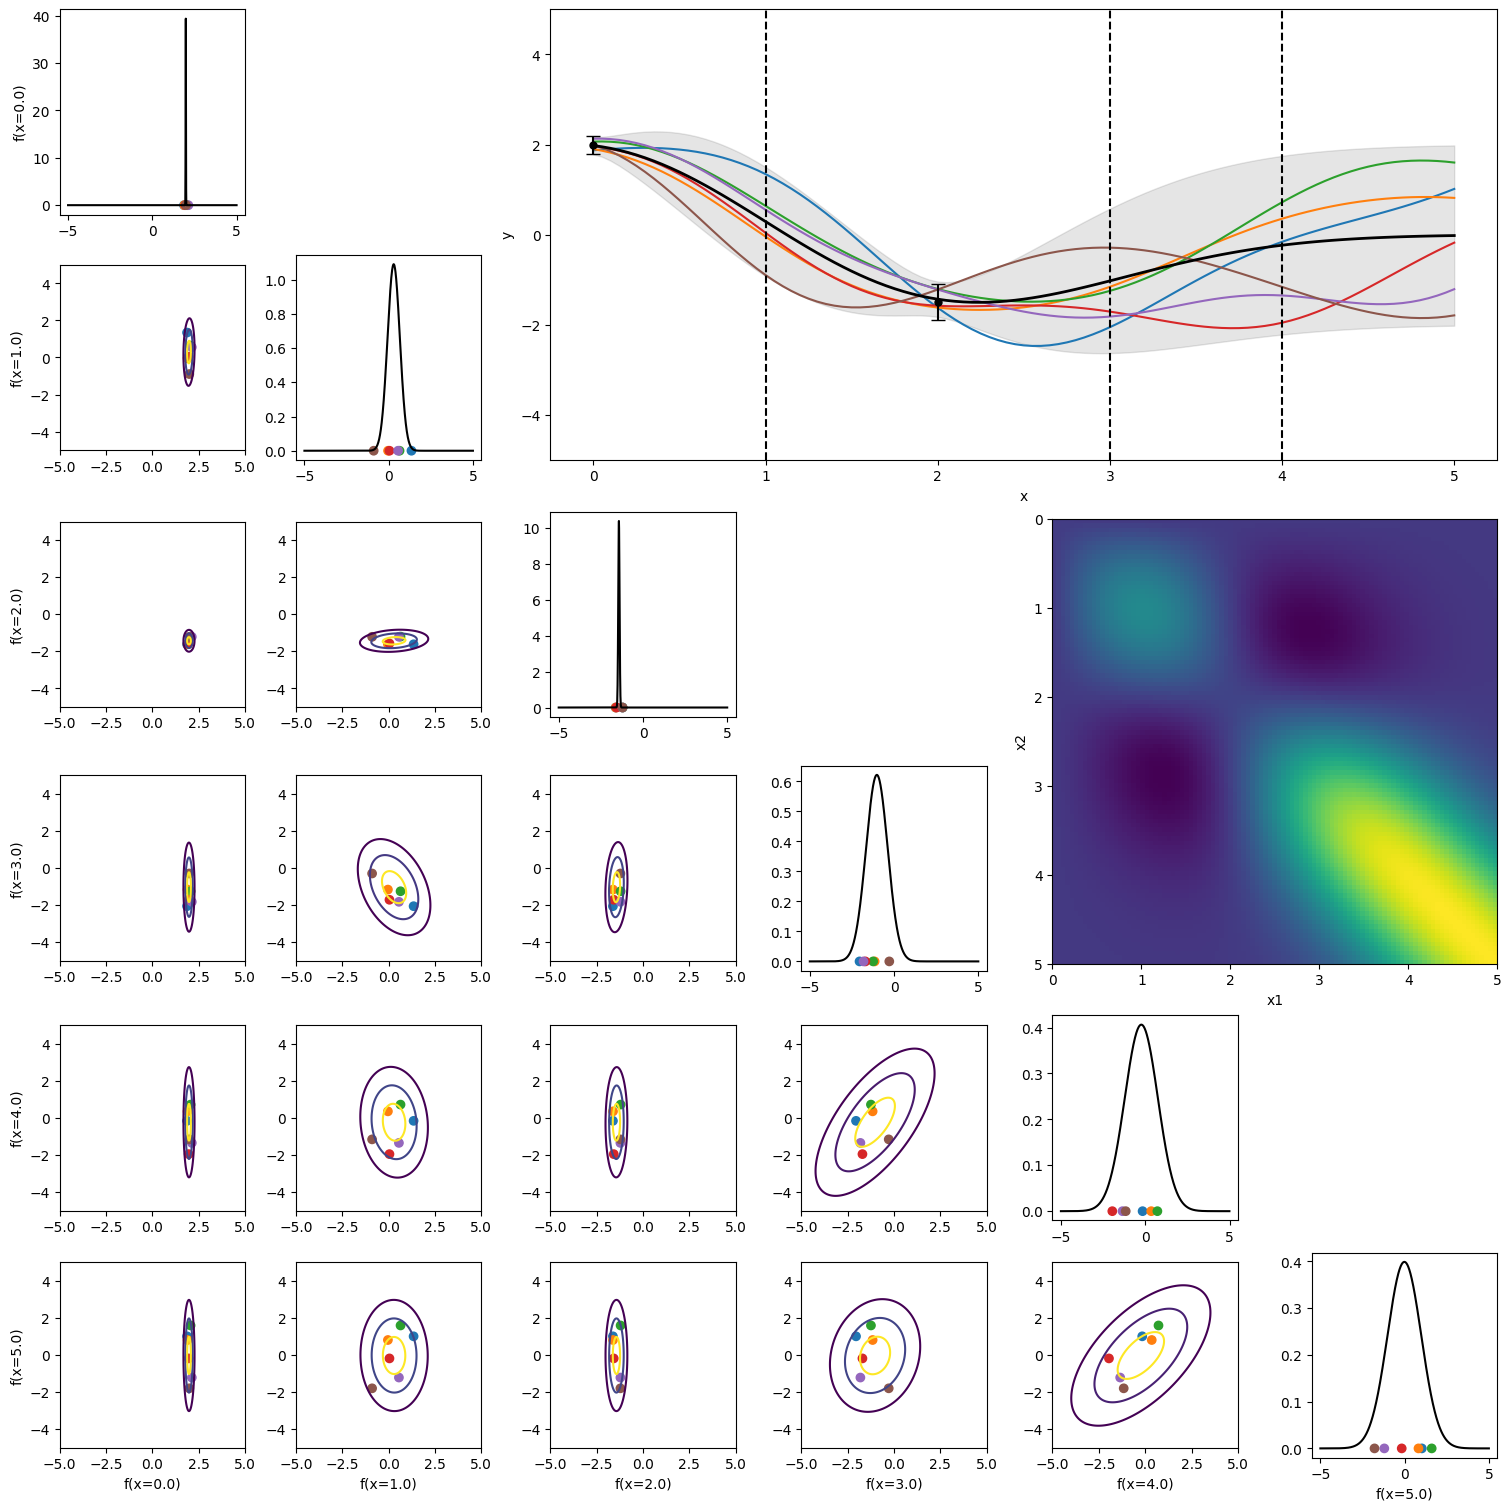

In [5]:
# Draw from the fit GP
draws = np.random.multivariate_normal(μ_star, Σ_star, 6)

# create the figure and subplots
fig2 = plt.figure(constrained_layout=True, figsize=(15, 15))
spec2 = gridspec.GridSpec(ncols=N_cols, nrows=N_cols, figure=fig2)

# plot draws
ax = fig2.add_subplot(spec2[0:2, 2:])
ax.plot(x_star, draws.T)
# plot observed data points
ax.errorbar(
    x_observed.flatten(),
    y_observed.flatten(),
    yerr=2 * σ.flatten(),
    ls='None',
    fmt='o',
    color='k',
    ms=5,
    zorder=10,
    capsize=5
)
# plot fitted mean with 2-sigma confidence shading
ax.plot(x_star, μ_star, 'k-', lw=2)
ax.fill_between(
    x_star,
    μ_star - 2 * σ_star,
    μ_star + 2 * σ_star,
    alpha=0.1,
    color='k'
)

# plot evaluation lines
ax.vlines(x_star[col_x[[1, 3, 4]]], -5, 5, linestyles='dashed', colors='k')
ax.set_ylim(-5, 5)
ax.set_xlabel('x')
ax.set_ylabel('y')

# plot fitted covariance
ax = fig2.add_subplot(spec2[2:4, 4:6])
ax.imshow(Σ_star, interpolation='none', origin='upper', extent=[0, 5, 5, 0])
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# corner plot
for ci, idx in enumerate(col_x):
    for cj, jdx in enumerate(col_x):
        if idx > jdx:
            ax = fig2.add_subplot(spec2[ci, cj])
            sub_μ = μ_star[[idx, jdx]]
            sub_Σ = Σ_star[[[idx], [jdx]], [idx, jdx]]
            rv = multivariate_normal(sub_μ, sub_Σ)

            rv_sigma=[
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 3 * sub_Σ[1, 1]**0.5))),  # 3-σ
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 2 * sub_Σ[1, 1]**0.5))),  # 2-σ
                rv.pdf(np.dstack((sub_μ[0], sub_μ[1] + 1 * sub_Σ[1, 1]**0.5)))   # 1-σ
            ]
            ax.contour(yvals, xvals, rv.pdf(pos), rv_sigma)
            xi = draws[:, col_x[ci]]
            xj = draws[:, col_x[cj]]
            plt.scatter(xj, xi, c=[f'C{i}' for i in range(6)])
            ax.set_aspect(1)
            ax.set_ylim(-5, 5)
            ax.set_xlim(-5, 5)
            if jdx == 0:
                ax.set_ylabel(f'f(x={x_star[idx]:.3})')
            if idx == N - 1:
                ax.set_xlabel(f'f(x={x_star[jdx]:.3})')
        elif idx == jdx:
            ax = fig2.add_subplot(spec2[ci, cj])
            ax.plot(xvals[:, 0], norm.pdf(xvals[:, 0], μ_star[idx], Σ_star[idx, idx]), 'k')
            xi = draws[:, col_x[ci]]
            xj = np.zeros_like(xi)
            plt.scatter(xi, xj, c=[f'C{i}' for i in range(6)])
            if idx == 0:
                ax.set_ylabel(f'f(x={x_star[idx]:.3})')
            if idx == N - 1:
                ax.set_xlabel(f'f(x={x_star[idx]:.3})')


## What about $h$

In this case we were assuming $h$ was a know fixed value, but on real data we likely don't know what $h$'s value should be.  In geneal any inputs into the kernel function can be treated as *hyperparameters* and an hierarchical Bayesian model and fit to the observed data.

## So this is like a spline?

Yes!  With a bit of math you can show that a cubic spline is just a special case of GPR (with a very specific kernel).  It turns out that many things are too, including:
- Spline fitting (any order)
- Support Vector Machines
- Least-square fitting (this is the special case of a diagonal $\Sigma$)
- Neural Networks
    - Every network architecture has an equivalent kernel